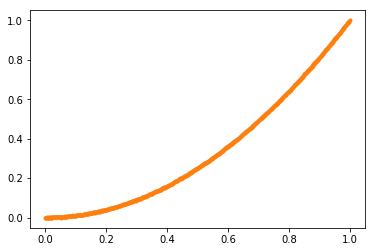

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
#np.random.seed(99)
f = lambda x: 1*x**2
xgrid = np.linspace(0.,1., 640)
fgrid = f(xgrid)
ygrid = fgrid + 0.001*np.random.normal(size=640)

%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(xgrid, fgrid, lw=2)
plt.plot(xgrid, ygrid, '.')


xdata = Variable(torch.Tensor(xgrid))
ydata = Variable(torch.Tensor(ygrid))



In [4]:
import torch
print(torch.__version__)

0.4.0


In [97]:
import pickle

train_xyz = []

with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    nv = obj.shape[1]
    if(nv == 5):
        train_xyz.append((obj.T.reshape(1,3,nv)))   
        
train_xyz = torch.squeeze(torch.Tensor(train_xyz))
train_xyz.shape        

torch.Size([1370, 3, 5])

In [98]:
train_xy = []

with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    nv = obj.shape[1]
    if(nv == 5):
        obj.T.reshape(1,3,nv)[0][2]=np.zeros(nv)
        train_xy.append(obj.T.reshape(1,3,nv))
train_xy = torch.squeeze(torch.Tensor(train_xy))
train_xy.shape        

torch.Size([1370, 3, 5])

In [99]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
x = torch.tensor([5.5, 3])
if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

cuda is available
tensor([ 6.5000,  4.0000], device='cuda:0')
tensor([ 6.5000,  4.0000], dtype=torch.float64)


In [8]:
from functools import reduce
def num_edges(n):
    #return reduce((lambda x,y: x+y),range(1,n-1))
    return int(n*(n-1)/2)

num_edges(4)

6

In [6]:
def create_edge_conn_mask(vertices):
    #dimension of mask is num_edges x vertices
    num_edge = num_edges(vertices)
    #create 3x3 array units
    wt_pos = np.array([[1,0,0],[0,1,0],[0,0,1]])
    wt_neg = np.array([[-1,0,0],[0,-1,0],[0,0,-1]])
    wt_zero = np.array([[0,0,0],[0,0,0],[0,0,0]])

    result = np.empty((1,vertices*3))
    #print(result)
    for r in range(num_edge):
        v = vertices - r -1
        for s in range(v):
            #print(r,r+s+1)
            conn = np.tile(wt_zero,vertices-2)
            conn = np.insert(conn, r*3, wt_pos, axis=1)
            conn = np.insert(conn, (r+s+1)*3, wt_neg, axis=1)
            #print(conn.shape)
            result = np.concatenate([result, conn])
    return(np.delete(result, 0, 0))        
            
create_edge_conn_mask(4).shape            

(18, 12)

The first attempt at this network will solve depth coordinates for maximum of $N_v$ = 8 vertices.

Layer 0 - Input layer:
The number of input parameters will be 8x3 (x,y and random z) parameter for each vertex. The first layer is 24 units. 

Layer 1 - Edge layer:
Each vertex is paired with every other vertex once to compute edge parameters. So, corresponding to the number of vertex, the number of edges are $(N_v-1) + (N_v-2) + ... + 1$ Only the existing edges are allowed to proceed in the flow and the non-existing edges are dropped out or zero-ed out. 



In [7]:
class Dropout(nn.Module):
    def __init__(self, p=0.999, inplace=False):
        super(Dropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.inplace = inplace

    def forward(self, input):
        return fn.dropout(input, self.p, self.training, self.inplace)

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) \
            + inplace_str + ')'

class MyLinear(nn.Linear):
    def __init__(self, in_feats, out_feats, drop_p, bias=True):
        super(MyLinear, self).__init__(in_feats, out_feats, bias=bias)
        self.masker = Dropout(p=drop_p)
        self.weight = torch.nn.Parameter(torch.from_numpy(create_edge_conn_mask(int(in_feats/3))))

    def forward(self, input):
        masked_weight = self.masker(self.weight)
        masked_weight = create_edge_conn_mask(int(self.in_feats/3))
        return F.linear(input, masked_weight, self.bias)
    

In [8]:
#old version
class DepthEstNet(nn.Module):
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        input_dim = vertices*3
        edge_dim = int(num_edges(vertices)*3)
        self.fc_initial = MyLinear(input_dim, edge_dim, 1)
        self.fc_mid = nn.ModuleList()
        self.fc_final = nn.Linear(edge_dim, int(input_dim/3))
        self.nonlinearity = nonlinearity

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.nonlinearity(x)
        for i in range(self.additional_hidden_wide):
            x = self.fc_mid[i](x)
            x = self.nonlinearity(x)
        x = self.fc_final(x)
        return x

In [9]:
# test pooling operation
# pool of size=3, stride=3import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib


m = nn.LPPool1d(2, 3, stride=3)
input = torch.randn(6,1,3)
print(input)
output = m(input)
print(output)

tensor([[[-0.3678,  1.6846, -0.9180]],

        [[-0.3115, -1.2350, -0.6745]],

        [[-0.2620,  0.2505,  0.6861]],

        [[-0.7283,  0.9187,  0.0847]],

        [[ 1.0293, -1.5432, -2.2132]],

        [[-0.3255, -0.1548, -1.3783]]])
tensor([[[ 1.9534]],

        [[ 1.4413]],

        [[ 0.7759]],

        [[ 1.1754]],

        [[ 2.8877]],

        [[ 1.4247]]])


In [389]:
def normalize(arr):
    ss = np.sqrt(sum(map(lambda x:x*x,arr)))
    return arr/ss
normalize(np.array([1,1,1]))


tensor([[ 0.5774,  0.5774,  0.5774]])

In [391]:
F.normalize(torch.Tensor(np.array([[1,1,1]])),p=2,dim=0)

tensor([[ 1.,  1.,  1.]])

In [504]:
# test normalization layers
in_ = torch.randn(1,3,10)
edge_vec = np.array([[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]]])
test_vec = np.array([[[ 0.5644,  0.6305,  0.0000,  0.5644,  1.1949,  0.0000,  0.0000,
           0.0000,  0.0000,  0.2223],
         [ 0.0000,  0.0000,  1.1567,  0.0000,  0.0000,  0.6774,  0.0094,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.6645,  0.0000,  0.5977,  0.0000,  0.0000,  0.0000,  0.0000,
           0.5977,  0.0000,  0.0000],
         [ 1.3575,  0.0000,  0.2252,  1.0370,  0.0000,  0.0000,  1.2622,
           0.2252,  0.0000,  1.2622],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 1.3129,  0.0000,  0.0000,  0.0000,  1.3129,  0.0000,  0.0000,
           0.8431,  0.0000,  0.8431],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.8412,  0.0000,  0.0000,  0.0000,  0.1727,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.3269,  1.3590,  0.0000,  0.0000,  1.6859,  0.8891,  0.0000,
           1.2160,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.4077,  0.0000,  0.0000,  0.0000,  0.4077,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 1.5721,  0.0000,  0.1484,  0.0000,  1.5721,  0.1484,  0.0000,
           1.7205,  0.0000,  1.2506],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.2555,  0.0000,  0.2555,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 1.3330,  0.2946,  0.0000,  0.2946,  1.6277,  0.0000,  0.0000,
           0.8632,  0.0000,  1.1578],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.5644,  0.6305,  0.0000,  0.5644,  1.1949,  0.0000,  0.0000,
           0.0000,  0.0000,  0.2223],
         [ 0.0000,  0.0000,  1.1567,  0.0000,  0.0000,  0.6774,  0.0094,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.9573,  0.0000,  0.0000,  0.0000,  0.9573,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0366,  0.0000,  0.0000,  1.0366,  0.3420,
           0.0000,  0.3420,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  1.2856,  0.0000,  0.1259,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.2962,  0.0000,  0.0000,  0.4101,  0.0000,  0.0000,  0.2962,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.3822,  0.2103,  0.0000,  0.9345,  0.5925,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0402],
         [ 0.0053,  0.3113,  0.8807,  0.0000,  0.3166,  1.1920,  0.0000,
           1.1973,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.8919,  0.0000,  0.0000,  0.7966,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5409,  0.0321,  0.0000,  0.0000,  0.5730,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  1.1949,  0.0000,  0.0000,  1.1949,  0.7345,
           0.1184,  0.7345,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.5751,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]]])
in_ = torch.Tensor(edge_vec)
n,d,e = output.size()
in_ = in_.sum(1)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
print(in_)
print(in_.shape)
print(in_[0])
print(torch.mm(in_.transpose(1,0),in_))



tensor([[ 18.,  21.,  24.,  27.,  30.]])
torch.Size([1, 5])
tensor([ 18.,  21.,  24.,  27.,  30.])
tensor([[ 324.,  378.,  432.,  486.,  540.],
        [ 378.,  441.,  504.,  567.,  630.],
        [ 432.,  504.,  576.,  648.,  720.],
        [ 486.,  567.,  648.,  729.,  810.],
        [ 540.,  630.,  720.,  810.,  900.]])


In [ ]:
m = nn.LayerNorm(10)
out_ = m(in_)
print("input shape = ", in_.shape)
print(in_)

for i in range(in_.shape[2]):
    print("transposed input = ", in_.transpose(2,1)[0][i])
    print(normalize(in_.transpose(2,1)[0][i]))
#print(normalize(in_[0][1]))
#print(normalize(in_[0][2]))

x = F.normalize(in_, p=2, dim=1)
print("x =", x)

In [411]:
# test con1D operation
# pool of size=3, stride=3
# class torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
input = torch.rand(5, 3, 5)
for i in range(1,5):
    m = nn.Conv1d(3, 3, 2, stride=1,dilation=i)
    m.weight=torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],

            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
    m.bias=torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
    if (i==1):
        output = m(input)
    else:
        print(output.shape); print(output)
        print(m(input).shape); print(m(input))
        output=torch.cat((output,m(input)), dim=2)
    #print(input)
    #print(m.weight)
    
print(output)
print(F.normalize(output, p=2, dim=1))

torch.Size([5, 3, 4])
tensor([[[ 0.5264, -0.5998,  0.3425, -0.2342],
         [-0.4754,  0.4946, -0.1206, -0.6928],
         [ 0.1549, -0.0064,  0.2327, -0.2329]],

        [[-0.3029,  0.5425, -0.0595, -0.2281],
         [-0.0585,  0.5623, -0.7692,  0.2781],
         [-0.2535,  0.3199,  0.1724, -0.5002]],

        [[ 0.0084,  0.8596, -0.6187,  0.3346],
         [ 0.2784, -0.2044, -0.5050,  0.4823],
         [-0.2235,  0.3618, -0.6413,  0.6770]],

        [[ 0.3188,  0.4701, -0.3981, -0.3161],
         [ 0.1562,  0.0603,  0.0741, -0.0442],
         [ 0.2286, -0.5501,  0.5765, -0.5487]],

        [[-0.0273,  0.5543, -0.1082, -0.8174],
         [ 0.3406,  0.1102,  0.3792, -0.8021],
         [ 0.1437, -0.2234,  0.4198,  0.0939]]])
torch.Size([5, 3, 3])
tensor([[[-0.0733, -0.2572,  0.1083],
         [ 0.0192,  0.3740, -0.8134],
         [ 0.1485,  0.2262, -0.0002]],

        [[ 0.2396,  0.4830, -0.2875],
         [ 0.5038, -0.2069, -0.4910],
         [ 0.0664,  0.4922, -0.3279]],

        [

In [45]:
# test 1D deconv layer
#input = torch.rand(5, 3, 5)

input = torch.Tensor([[[ 0.8,  0.7,  0.6,  0.50,  0.4],
         [ 0.50,  0.6,  0.7,  0.8,  0.9],
         [ 0.4,  0.3,  0.2,  1.0,  0.0]]])

print("input", input)
for i in range(1,5):
    print(" i = ", i)
    m = nn.Conv1d(3, 3, 2, stride=1,dilation=i)
    m.weight=torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],

            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
    m.bias=torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
    if (i==1):
        output = m(input)
    else:  
        output=torch.cat((output,m(input)), dim=2)
        
    print("current output shape:", m(input).shape); print("current output:", m(input))    
print("***")   
print("overall output shape:", output.shape); print("overall output:", output)
    #print(m.weight)

print("*************** DE CONV *****************")        
input = output    
print("input", input)

#1D deconv to obtain input vector
for i in range(1,5):
    print(" i = ", i)
    m = nn.ConvTranspose1d(3, 3, 2, stride=i,dilation=1)
    m.weight=torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],

            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
    m.bias=torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
    if (i==1):
        output = m(input)
    else:
        maxp = nn.MaxPool1d(3, stride=1, dilation=5-i)
        #curr = maxp(m(input))
        output=torch.cat((output,m(input)), dim=2)
          
    print("current output shape:", m(input).shape); print("current output:", m(input))   
print("***")       
print("overall output shape:", output.shape); print("overall output:", output)
    #print(m.weight)

input tensor([[[ 0.8000,  0.7000,  0.6000,  0.5000,  0.4000],
         [ 0.5000,  0.6000,  0.7000,  0.8000,  0.9000],
         [ 0.4000,  0.3000,  0.2000,  1.0000,  0.0000]]])
 i =  1
current output shape: torch.Size([1, 3, 4])
current output: tensor([[[ 0.1000,  0.1000,  0.1000,  0.1000],
         [-0.1000, -0.1000, -0.1000, -0.1000],
         [ 0.1000,  0.1000, -0.8000,  1.0000]]])
 i =  2
current output shape: torch.Size([1, 3, 3])
current output: tensor([[[ 0.2000,  0.2000,  0.2000],
         [-0.2000, -0.2000, -0.2000],
         [ 0.2000, -0.7000,  0.2000]]])
 i =  3
current output shape: torch.Size([1, 3, 2])
current output: tensor([[[ 0.3000,  0.3000],
         [-0.3000, -0.3000],
         [-0.6000,  0.3000]]])
 i =  4
current output shape: torch.Size([1, 3, 1])
current output: tensor([[[ 0.4000],
         [-0.4000],
         [ 0.4000]]])
***
overall output shape: torch.Size([1, 3, 10])
overall output: tensor([[[ 0.1000,  0.1000,  0.1000,  0.1000,  0.2000,  0.2000,  0.2000,
    

In [100]:
# new version
import torch.nn.functional as F 


class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        input_dim = vertices * 3
        edges = int(num_edges(vertices))
        edge_dim = edges * 3
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        for i in range(1,vertices):
            #torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            self.conv_edge_vec.append(m)
        
        #self.fc_initial = MyLinear(input_dim, edge_dim, 1)
        #self.fc_mid = nn.ModuleList()
        self.layernorm = nn.LayerNorm(edges)
        #self.fc_final = nn.Linear(int(vertices*2), int(vertices))
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    def forward(self, x):
        #x = self.fc_initial(x)
        #x = self.nonlinearity(x)
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
                
        #print("convolution output == ",output)    
        #print("output.shape == ", output.shape)
        #print("output.transpose ==", output.transpose(1,2))
        #output is now Batch_Size X Nv(Nv-1)/2 X 3
        #print("outout.shape == ", output.transpose(1,2).shape)
        #y = output.transpose(1,2)
        #y = self.layernorm(output)
        
        output = F.normalize(output, p=2, dim=1)
        
        #y = self.fc_final(output)
        #print("output post layer norm == ", output)
        
        #pool all dimensions for Gram Matrix
        
        n,d,e = output.size()
        y = output.reshape(n, d, e).sum(1)
        
        #print(y.shape) # Batch X Num_Edges
        y = y/y.norm(dim=1)[:,None]
        #print(y)
        output = torch.mm(y.transpose(1,0),y)
        
        #print("cosine similarity --> ", output)
        
        return output

In [101]:
model = DepthEstNet(5, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.MSELoss()
print(model)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
  )
  (layernorm): LayerNorm(torch.Size([10]), eps=1e-05, elementwise_affine=True)
  (cos): CosineSimilarity()
)


In [102]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [

In [103]:
print(model.forward(train_xy))

tensor([[ 230.5156,  118.4885,  130.8626,  108.4867,  132.2863,  102.8049,
          106.4930,   96.4470,   48.5143,   88.7583],
        [ 118.4885,  174.4635,   74.1462,   87.8946,   64.4498,   93.8680,
           57.8412,   44.6356,   48.5259,   49.0191],
        [ 130.8626,   74.1462,  151.8619,   75.5160,   75.3431,   82.4570,
          105.0592,   60.6885,   42.7144,   51.1704],
        [ 108.4867,   87.8946,   75.5160,  154.7221,   71.6376,   58.9114,
           82.2046,   52.2689,   22.9975,   56.7549],
        [ 132.2863,   64.4498,   75.3431,   71.6376,  139.2807,   71.9200,
           41.6662,   85.2769,   17.1101,   81.5406],
        [ 102.8049,   93.8680,   82.4570,   58.9114,   71.9200,  130.3176,
           54.9045,   51.9858,   68.9735,   45.2741],
        [ 106.4930,   57.8412,  105.0592,   82.2046,   41.6662,   54.9045,
          118.7373,   35.3610,   33.7144,   40.3869],
        [  96.4470,   44.6356,   60.6885,   52.2689,   85.2769,   51.9858,
           35.3610,  1

In [89]:
print(model.forward(train_xy))

tensor([[ 1.8351,  1.0100,  0.9076,  0.9693,  1.3868,  0.9153,  0.8009,
          1.0865,  0.1667,  1.0687],
        [ 1.0100,  1.4718,  0.6730,  0.9152,  1.0864,  0.8431,  0.4692,
          0.4888,  0.0000,  0.5686],
        [ 0.9076,  0.6730,  1.2383,  0.6777,  0.9344,  1.0336,  0.7422,
          0.6170,  0.3333,  0.6545],
        [ 0.9693,  0.9152,  0.6777,  1.2338,  0.5651,  0.5188,  0.8139,
          0.6045,  0.1667,  0.6523],
        [ 1.3868,  1.0864,  0.9344,  0.5651,  1.6015,  1.1210,  0.4167,
          0.8750,  0.1667,  0.9384],
        [ 0.9153,  0.8431,  1.0336,  0.5188,  1.1210,  1.2037,  0.5833,
          0.5824,  0.3333,  0.4956],
        [ 0.8009,  0.4692,  0.7422,  0.8139,  0.4167,  0.5833,  0.9259,
          0.3255,  0.3333,  0.3733],
        [ 1.0865,  0.4888,  0.6170,  0.6045,  0.8750,  0.5824,  0.3255,
          1.1624,  0.1667,  0.7798],
        [ 0.1667,  0.0000,  0.3333,  0.1667,  0.1667,  0.3333,  0.3333,
          0.1667,  0.3333,  0.0000],
        [ 1.0687,  

In [104]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy, train_xyz)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)
dataset

In [105]:
torch.Tensor.new_zeros(train_xy,[1,1])

tensor([[ 0.]])

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


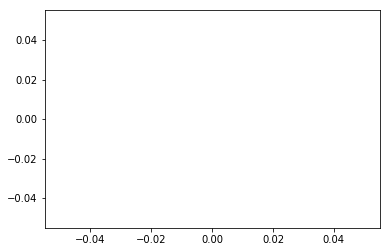

In [108]:
lr, epochs, batch_size = 1e-1 , 10 , 20
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        #print(xy, xyz)
        local_xy = Variable(xy)
        local_xyz = Variable(xyz)
        output = model.forward(local_xy)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

In [409]:
#new run for vertices==5

lr, epochs, batch_size = 1e-1 , 1000 , 2
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        #print(xy, xyz)
        local_xy = Variable(xy)
        local_xyz = Variable(xyz)
        output = model.forward(local_xy)
        loss = criterion(output, local_xyz)
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

convolution output ==  tensor([[[ 0.5644,  0.6305,  0.0000,  0.5644,  1.1949,  0.0000,  0.0000,
           0.0000,  0.0000,  0.2223],
         [ 0.0000,  0.0000,  1.1567,  0.0000,  0.0000,  0.6774,  0.0094,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  1.1949,  0.0000,  0.0000,  1.1949,  0.7345,
           0.1184,  0.7345,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.5751,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.2555,  0.0000,  0.2555,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 1.3330,  0.2946,  0.0000,  0.2946,  1.6277,  0.0000,  0.0000,
           0.8632,  0.0000,  1.1578],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0

RuntimeError: input and target shapes do not match: input [5 x 3 x 10], target [5 x 3 x 5] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THNN/generic/MSECriterion.c:13

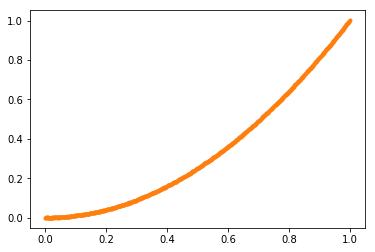

In [21]:

#np.random.seed(99)
f = lambda x: 1*x**2
xgrid = np.linspace(0.,1., 640)
fgrid = f(xgrid)
ygrid = fgrid + 0.001*np.random.normal(size=640)


plt.plot(xgrid, fgrid, lw=2)
plt.plot(xgrid, ygrid, '.')


xdata = Variable(torch.Tensor(xgrid))
ydata = Variable(torch.Tensor(ygrid))



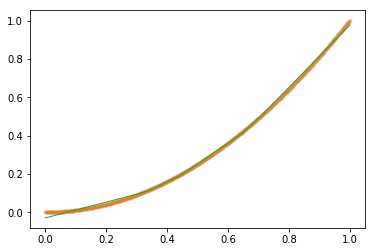

In [22]:
finaloutput = model.forward(xdata.view(-1,1))
plt.plot(xgrid, fgrid, '.', alpha=0.1)
plt.plot(xgrid, ygrid, '.', alpha=0.2)
plt.plot(xgrid, finaloutput.data.numpy(), lw=1)